In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from fngw import fngw_barycenters

In [2]:
def build_noise_graph(N, mean, std, proba=0.2):
    F = np.expand_dims(np.random.normal(mean, std, N) + np.sin(2*np.arange(N)*np.pi/N), axis=-1)
    C = np.zeros((N, N))
    for i in range(N):
        C[i, (i+1)%N] = 1
        C[(i+1)%N, i] = 2
        rv = np.random.uniform(size=1)
        if rv < proba:
            C[i, (i+2)%N] = 1
            C[(i+2)%N, i] = 2
    one_hots = np.eye(3)
    C = one_hots[C.astype('int')]

    A = 1 - C[:, :, 0]
    C = C[:, :, 1:]

    return {'F': F, 'C': C, 'A': A}

In [3]:
def show_graph(graph, color_maps, ax, thrs):
    C = graph['C']
    F = graph['F']
    A = graph['A']
    A = A < thrs
    D = np.argmax(C, axis=-1) + 1
    D[A] = 0
    graph = nx.from_numpy_array(D, create_using=nx.DiGraph)
    pos = nx.kamada_kawai_layout(graph)
    edge_colors = np.array([color_maps[int(edge[-1])-1] for edge in graph.edges.data("weight")])
    nx.draw(graph,
            pos,
            node_color=F.squeeze(), 
            vmin=-1.0, 
            vmax=1.0,
            edge_color=edge_colors,
            alpha=0.7,
            width=3,
            connectionstyle='arc3, rad = 0.3',
            ax=ax)

In [4]:
def get_barycentre(graphs, weights, alpha=0.33, beta=0.33, N=20):
    Fs = [x['F'] for x in graphs]
    Cs = [x['C'] for x in graphs]
    As = [x['A'] for x in graphs]
    if N is None:
        mean_size = int(
            np.mean([len(x['F']) for x in graphs])
        )
    else:
        mean_size = N

    internal_weights = [
        np.ones(len(x['F'])) / len(x['F'])
        for x in graphs
    ]

    F_bary, A_bary, C_bary = fngw_barycenters(
        N=mean_size,
        Fs=Fs,
        As=As,
        Cs=Cs,
        ps=internal_weights,
        lambdas=weights,
        alpha=alpha,
        beta=beta,
        dist_fun_C='l2_norm',
        dist_fun_A='square_loss',
        max_iter=100,
        tol=1e-9)

    return {'F': F_bary, 'C': C_bary, 'A': A_bary}

In [5]:
color_maps = ['blue', 'green']

### Generate random circle examples

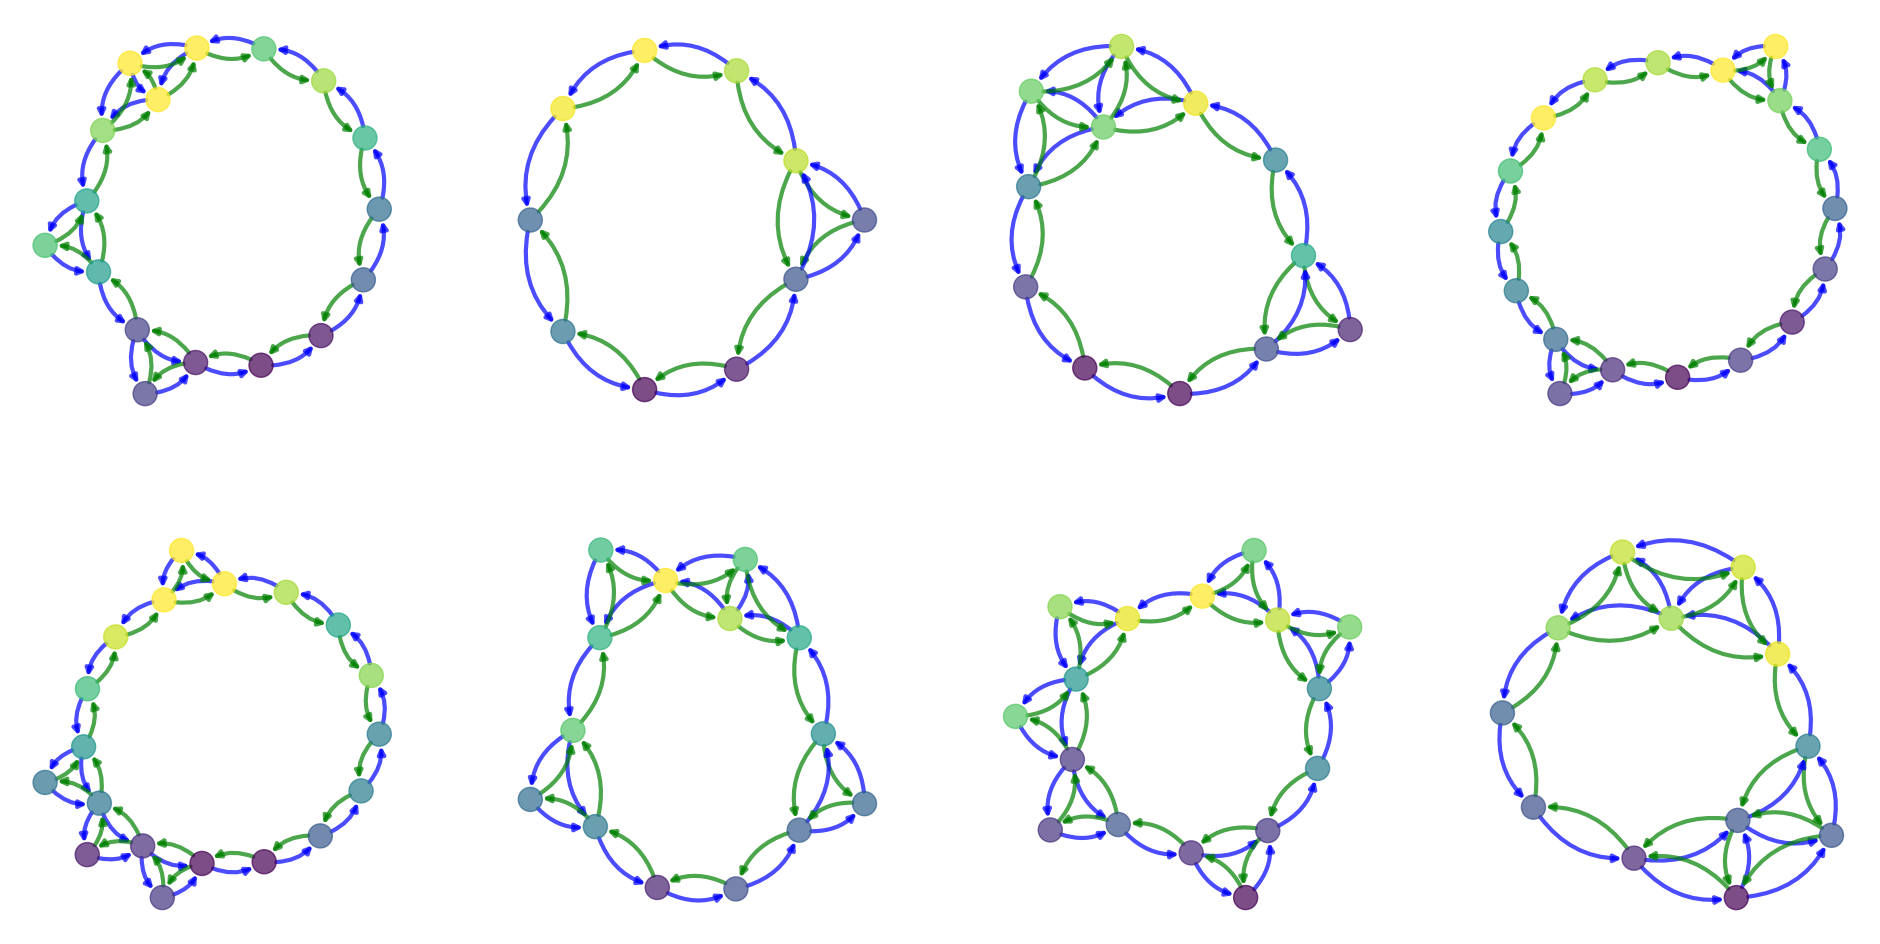

In [6]:
graphs = []
N_graph = 8
for i in range(N_graph):
    N = np.random.randint(10, 20)
    res = build_noise_graph(N=N, mean=0, std=0.3, proba=0.3)
    graphs.append(res)
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
for i in range(N_graph):
    show_graph(graphs[i], color_maps, ax=axes[i//4, i%4], thrs=0.5)

### Compute their barycenter with FNGW distance

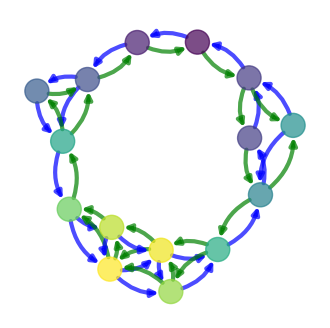

In [7]:
alpha = 0.4
beta = 0.4
N_nodes_bary = 15

g_bary = get_barycentre(graphs,
                        weights=np.ones(len(graphs))/len(graphs),
                        alpha=alpha,
                        beta=beta,
                        N=N_nodes_bary)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
show_graph(g_bary, color_maps, ax=ax, thrs=0.4)